In [2]:
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By

''' 
This program merges all of the separate programs (protagonists.ipynb and synopsis.ipynb) and adds the text search function. It will
return all of the movies that contain family keywords inside a data frame. This program runs in approximately 7-8 mins."
'''

def movie_table(url):
    webpage = url
    response = requests.get(webpage)

    page = response.text

    soup = BeautifulSoup(page, 'html.parser')
    beautiful_page = soup.get_text()

    ratings = []
    years = []
    titles = []
    movie_nums = []

    lines = beautiful_page.splitlines()

    for line in lines:
        if "(20" in line and ")" in line or '(19' in line and ')' in line:
            years.append(line)

    rep_years = []
    nrep_years = []
    year_indices = []

    for year in years:
        
        if lines.count(year) > 1:
            if year not in rep_years:
                rep_years.append(year)
        if lines.count(year) == 1:
            nrep_years.append(year)

    for i in range(len(rep_years)):
        first_instance = lines.index(rep_years[i])
        year_indices.append(first_instance)

        for j, item in enumerate(lines[first_instance+1:], start=first_instance+1):
            if item == rep_years[i]:
                year_indices.append(j)

    for year in nrep_years:
        if year in lines:
            index = lines.index(year)
            year_indices.append(index)


    for index in sorted(year_indices):
        title = lines[index-1]
        titles.append(title)

        rating = lines[index+6]
        ratings.append(rating)

        movie_num = lines[index-3]
        movie_nums.append(movie_num) 
        

    ratings = [rating.lstrip() for rating in ratings]
    for i in range(len(ratings)):
        if ratings[i] == '':
            ratings[i] = "None"


    for i in range(len(years)):
        for j in range(len(years[i])):
            if years[i][j].isnumeric():
                number_index = years[i].find(years[i][j])
                years[i] = years[i][number_index:number_index+4]
                break


    table_data = list(zip(movie_nums, titles, years, ratings))
    # headers = ["Movie Number", "Title", "Year", "Rating"]

    # print(tabulate(table_data, headers=headers))
    
    return table_data

synopsis_list = []

# Function to get the synopsis from every movie in the webpage
def synopses(link):
    webpage = link
    response = requests.get(webpage)

    page = response.text

    soup = BeautifulSoup(page, 'html.parser')

    url_list = []
    movie_url_list = []
    movie_ref_nums = []

    # Get all the hyperlinks
    for link in soup.find_all('a'):
        url_list.append(link.get('href'))

    # Filter to get movie title hyperlinks
    for url in url_list:
        if '/title/tt' in url:
            if url not in movie_url_list:
                movie_url_list.append(url) 

    # Take the reference number from the movie url
    for movie_url in movie_url_list:
        movie_ref_nums.append(movie_url[7:16])


    # Extract the synopsis from every movie then append to a list
    driver = webdriver.Chrome('/Users/nixoncarino/Desktop/chromedriver')

    for i in movie_ref_nums:
        url = "https://www.imdb.com/title/" + i + "/plotsummary/?ref_=tt_stry_pl#synopsis"
        try:
            driver.get(url)
            synopsis_element = driver.find_element(By.XPATH, '//*[@id="__next"]/main/div/section/div/section/div/div[1]/section[2]/div[2]/ul/li/div/div/div/div/div')
        except:
            synopsis_list.append("No Synopsis")
        else:
            synopsis = synopsis_element.text
            synopsis_list.append(synopsis)

# Function that find family related words on the synopsis
def text_search(synopsis_list):
    # The indices of the synopses that contain any of the keywords
    match_index_list = []

    keywords = ["family", "parenting", "father", "mother", "son", "daughter", "sibling", "brother", "sister", "marriage", "divorce", "blended family", "adoption",
                "foster care", "custody", "inheritance", "legacy", "generations", "multigenerational", "family reunion", "family secrets", "family drama", "dysfunctional", 
                "dysfunctional family", "family conflict", "family relationships", "family values", "family ties", "parent-child relationship", "relationship",
                "coming-of-age", "parenthood", "growing up", "childhood", "teenage years", "aging parents", "grandparents"]

    for i in range(len(synopsis_list)):
        for keyword in keywords:
            if keyword in synopsis_list[i]:
                if i not in match_index_list:
                    match_index_list.append(i)

    return match_index_list

# Call synopses function to put all synopses into list
synopses("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=adventure&view=simple")
synopses("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=adventure&view=simple&start=51&ref_=adv_nxt")

# Create Data Frame for Movie information
df_adventure_1 = pd.DataFrame(movie_table("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=adventure&view=simple"), 
                            columns=['Index', 'Title', 'Year', 'Rating'])
df_adventure_2 = pd.DataFrame(movie_table("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=adventure&view=simple&start=51&ref_=adv_nxt"), 
                            columns=['Index', 'Title', 'Year', 'Rating'])
df_adventure = pd.concat([df_adventure_1, df_adventure_2], ignore_index=True).assign(Genre='Adventure', Synopsis=synopsis_list)

# Output information of movies that contain family keywords
pd.set_option('display.max_rows', None)
full_adventure = df_adventure.iloc[text_search(synopsis_list)]
full_adventure

/var/folders/dr/q8lk9535757d9krftyrx8kgc0000gn/T/ipykernel_21300/4254273826.py:122: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/nixoncarino/Desktop/chromedriver')


,Index,Title,Year,Rating,Genre,Synopsis
0,1.,Guardians of the Galaxy Vol. 3,2023,8.3,Adventure,"As a baby raccoon, Rocket is a test subject fo..."
1,2.,Dungeons & Dragons: Honor Among Thieves,2023,7.4,Adventure,"Prior to imprisonment, bard Edgin Darvis serve..."
4,5.,Guardians of the Galaxy,2014,8,Adventure,"Earth, 1988:\n\nYoung Peter Quill (Wyatt Oleff..."
5,6.,Dune,2021,8,Adventure,The story opens with a woman telling a portion...
6,7.,Avatar: The Way of Water,2022,7.7,Adventure,Over a decade after the events of the first fi...
8,9.,Guardians of the Galaxy Vol. 2,2017,7.6,Adventure,"Missouri, Planet Earth, 1980\n\nMeredith Quill..."
9,10.,Everything Everywhere All at Once,2022,7.9,Adventure,Part 1: Everything\n\nEvelyn Wang (Yeoh) is a ...
13,14.,Star Wars: Episode VI - Return of the Jedi,1983,8.3,Adventure,The opening crawl reveals that Han Solo's frie...
14,15.,The Hunger Games,2012,7.2,Adventure,The nation of Panem is divided into 12 distric...
16,17.,Interstellar,2014,8.6,Adventure,A group of elderly people are giving interview...


In [3]:
#Analysis of adventure
isinstance(full_adventure, pd.DataFrame)
import matplotlib.pyplot as plt
import seaborn as sns
full_adventure_sorted = full_adventure.sort_values('Year')
full_adventure['Chronological Year'] = full_adventure_sorted['Year'].vmostalues
full_adventure

NameError: name 'full_adventure' is not defined

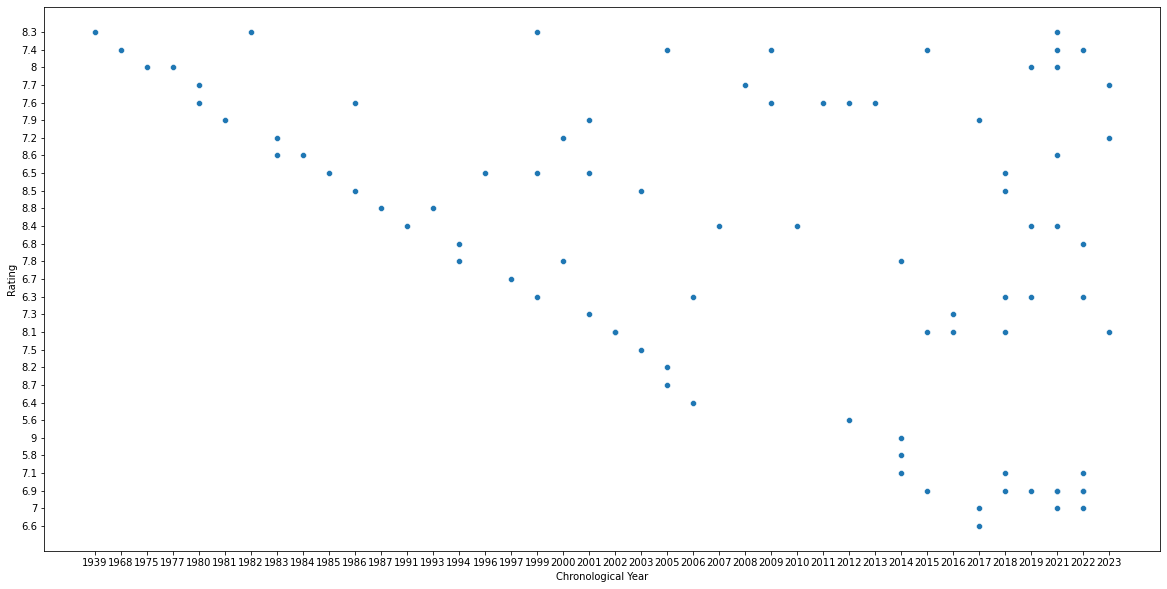

In [12]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='Chronological Year', y='Rating', data=full_adventure)
plt.show()

#for the top 100 adventure movies most of them are from more recent years, in 1999 the abundance of high rated adventure movies started occuring
#i.e. one predictable factor is whether the inputted age is after 1999

In [2]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = full_adventure.iloc[:,2:6]
Y = full_adventure.iloc[:,4]
best_adventure_features = SelectKBest(score_func=chi2, k=3)
fit_adventure = best_adventure_features.fit(X,Y)

NameError: name 'full_adventure' is not defined